# Self-Hosting LLM Chat Model on SageMaker 

Hugging Face Chatbot Arena Leaderboard: https://huggingface.co/spaces/lmsys/chatbot-arena-leaderboard <br>
Hugging Face LLM Leaderboard: https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard

### Input Open Source LLM in Hugging Face to deploy on SageMaker

In [1]:
print("Input Hugging Face Model ID")
print("---------------------------")
print("Example: TheBloke/Llama-2-7b-chat-fp16")
print("https://huggingface.co/models?pipeline_tag=text-generation")
print("")
HF_MODEL_ID = input()
print("")
print(f"HF_MODEL_ID = {HF_MODEL_ID}")

Input Hugging Face Model ID
---------------------------
Example: TheBloke/Llama-2-7b-chat-fp16
https://huggingface.co/models?pipeline_tag=text-generation



 TheBloke/Llama-2-7b-chat-fp16



HF_MODEL_ID = TheBloke/Llama-2-7b-chat-fp16


## Prerequisites

### Set up

---
We begin by installing and upgrading necessary packages. Restart the kernel after executing the cell below for the first time.

---

In [4]:
!pip install -Uq pip sagemaker transformers langchain

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.29.63 requires botocore==1.31.63, but you have botocore 1.33.1 which is incompatible.
awscli 1.29.63 requires s3transfer<0.8.0,>=0.7.0, but you have s3transfer 0.8.0 which is incompatible.


In [3]:
### restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [4]:
import sagemaker

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
region = sess._region_name  # region name of the current SageMaker Studio environment
account_id = sess.account_id()  # account_id of the current SageMaker Studio environment
bucket = sess.default_bucket()  # bucket to house artifacts

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## LLM Deployment with SageMaker Endpoint

### Option A: SageMaker JumpStart (Console)

https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html<br>
https://aws.amazon.com/sagemaker/jumpstart/getting-started/

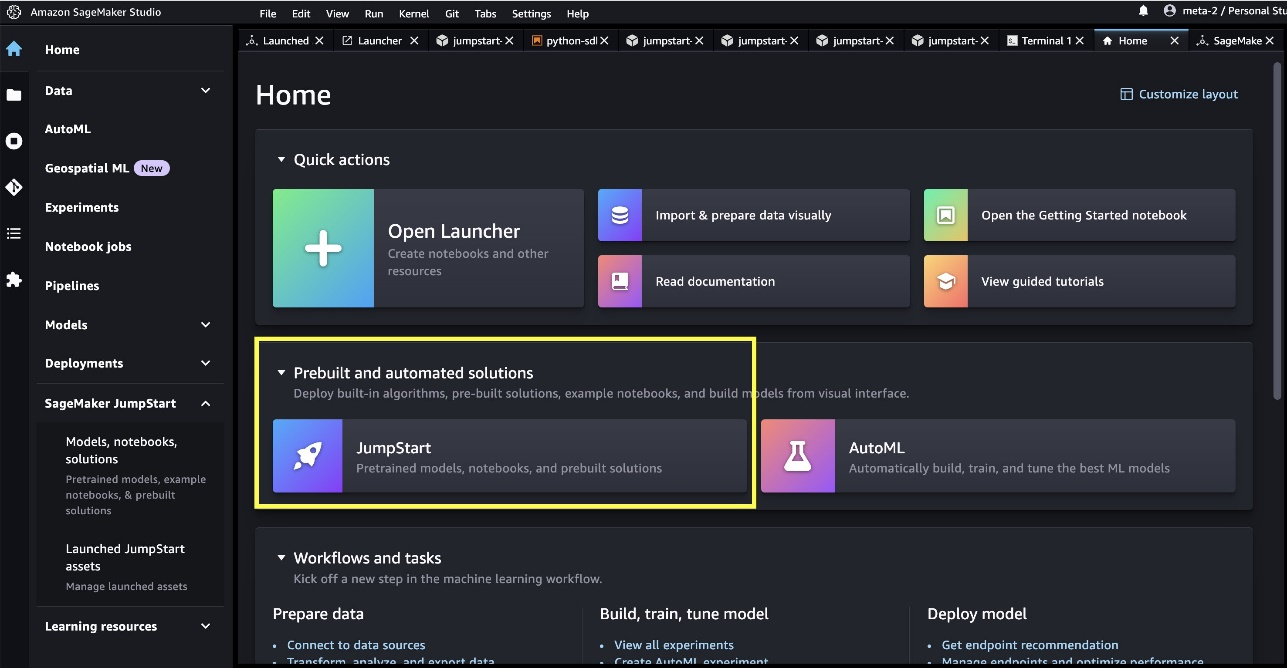

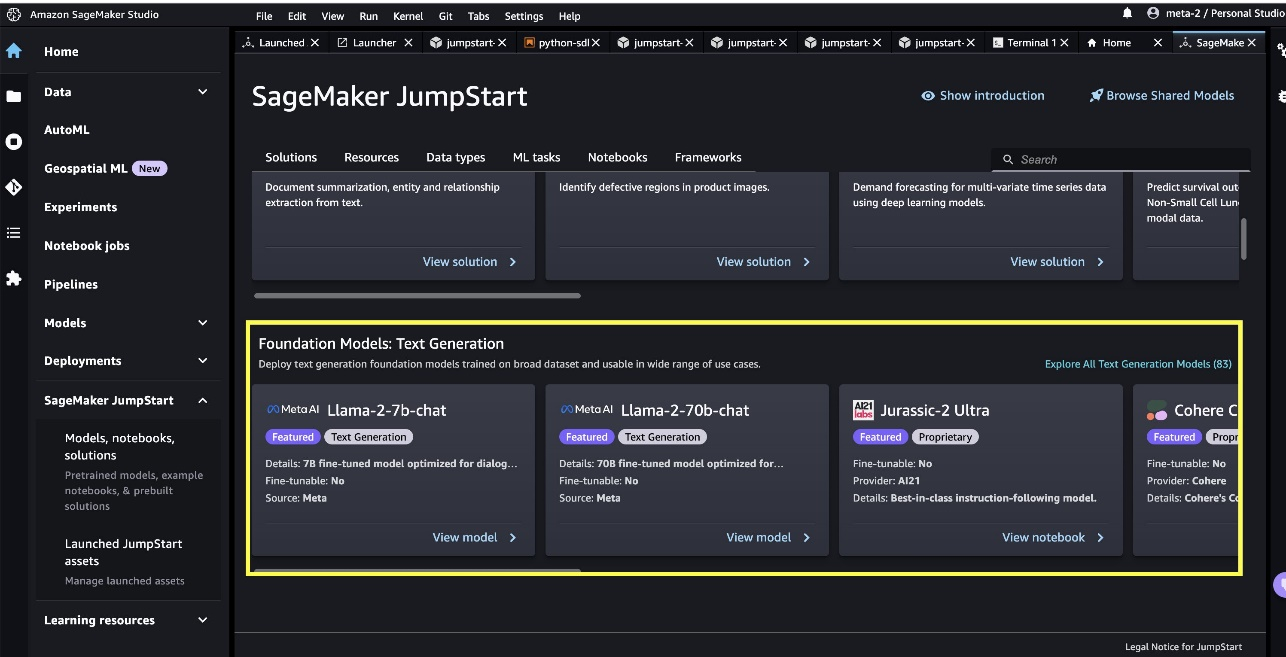

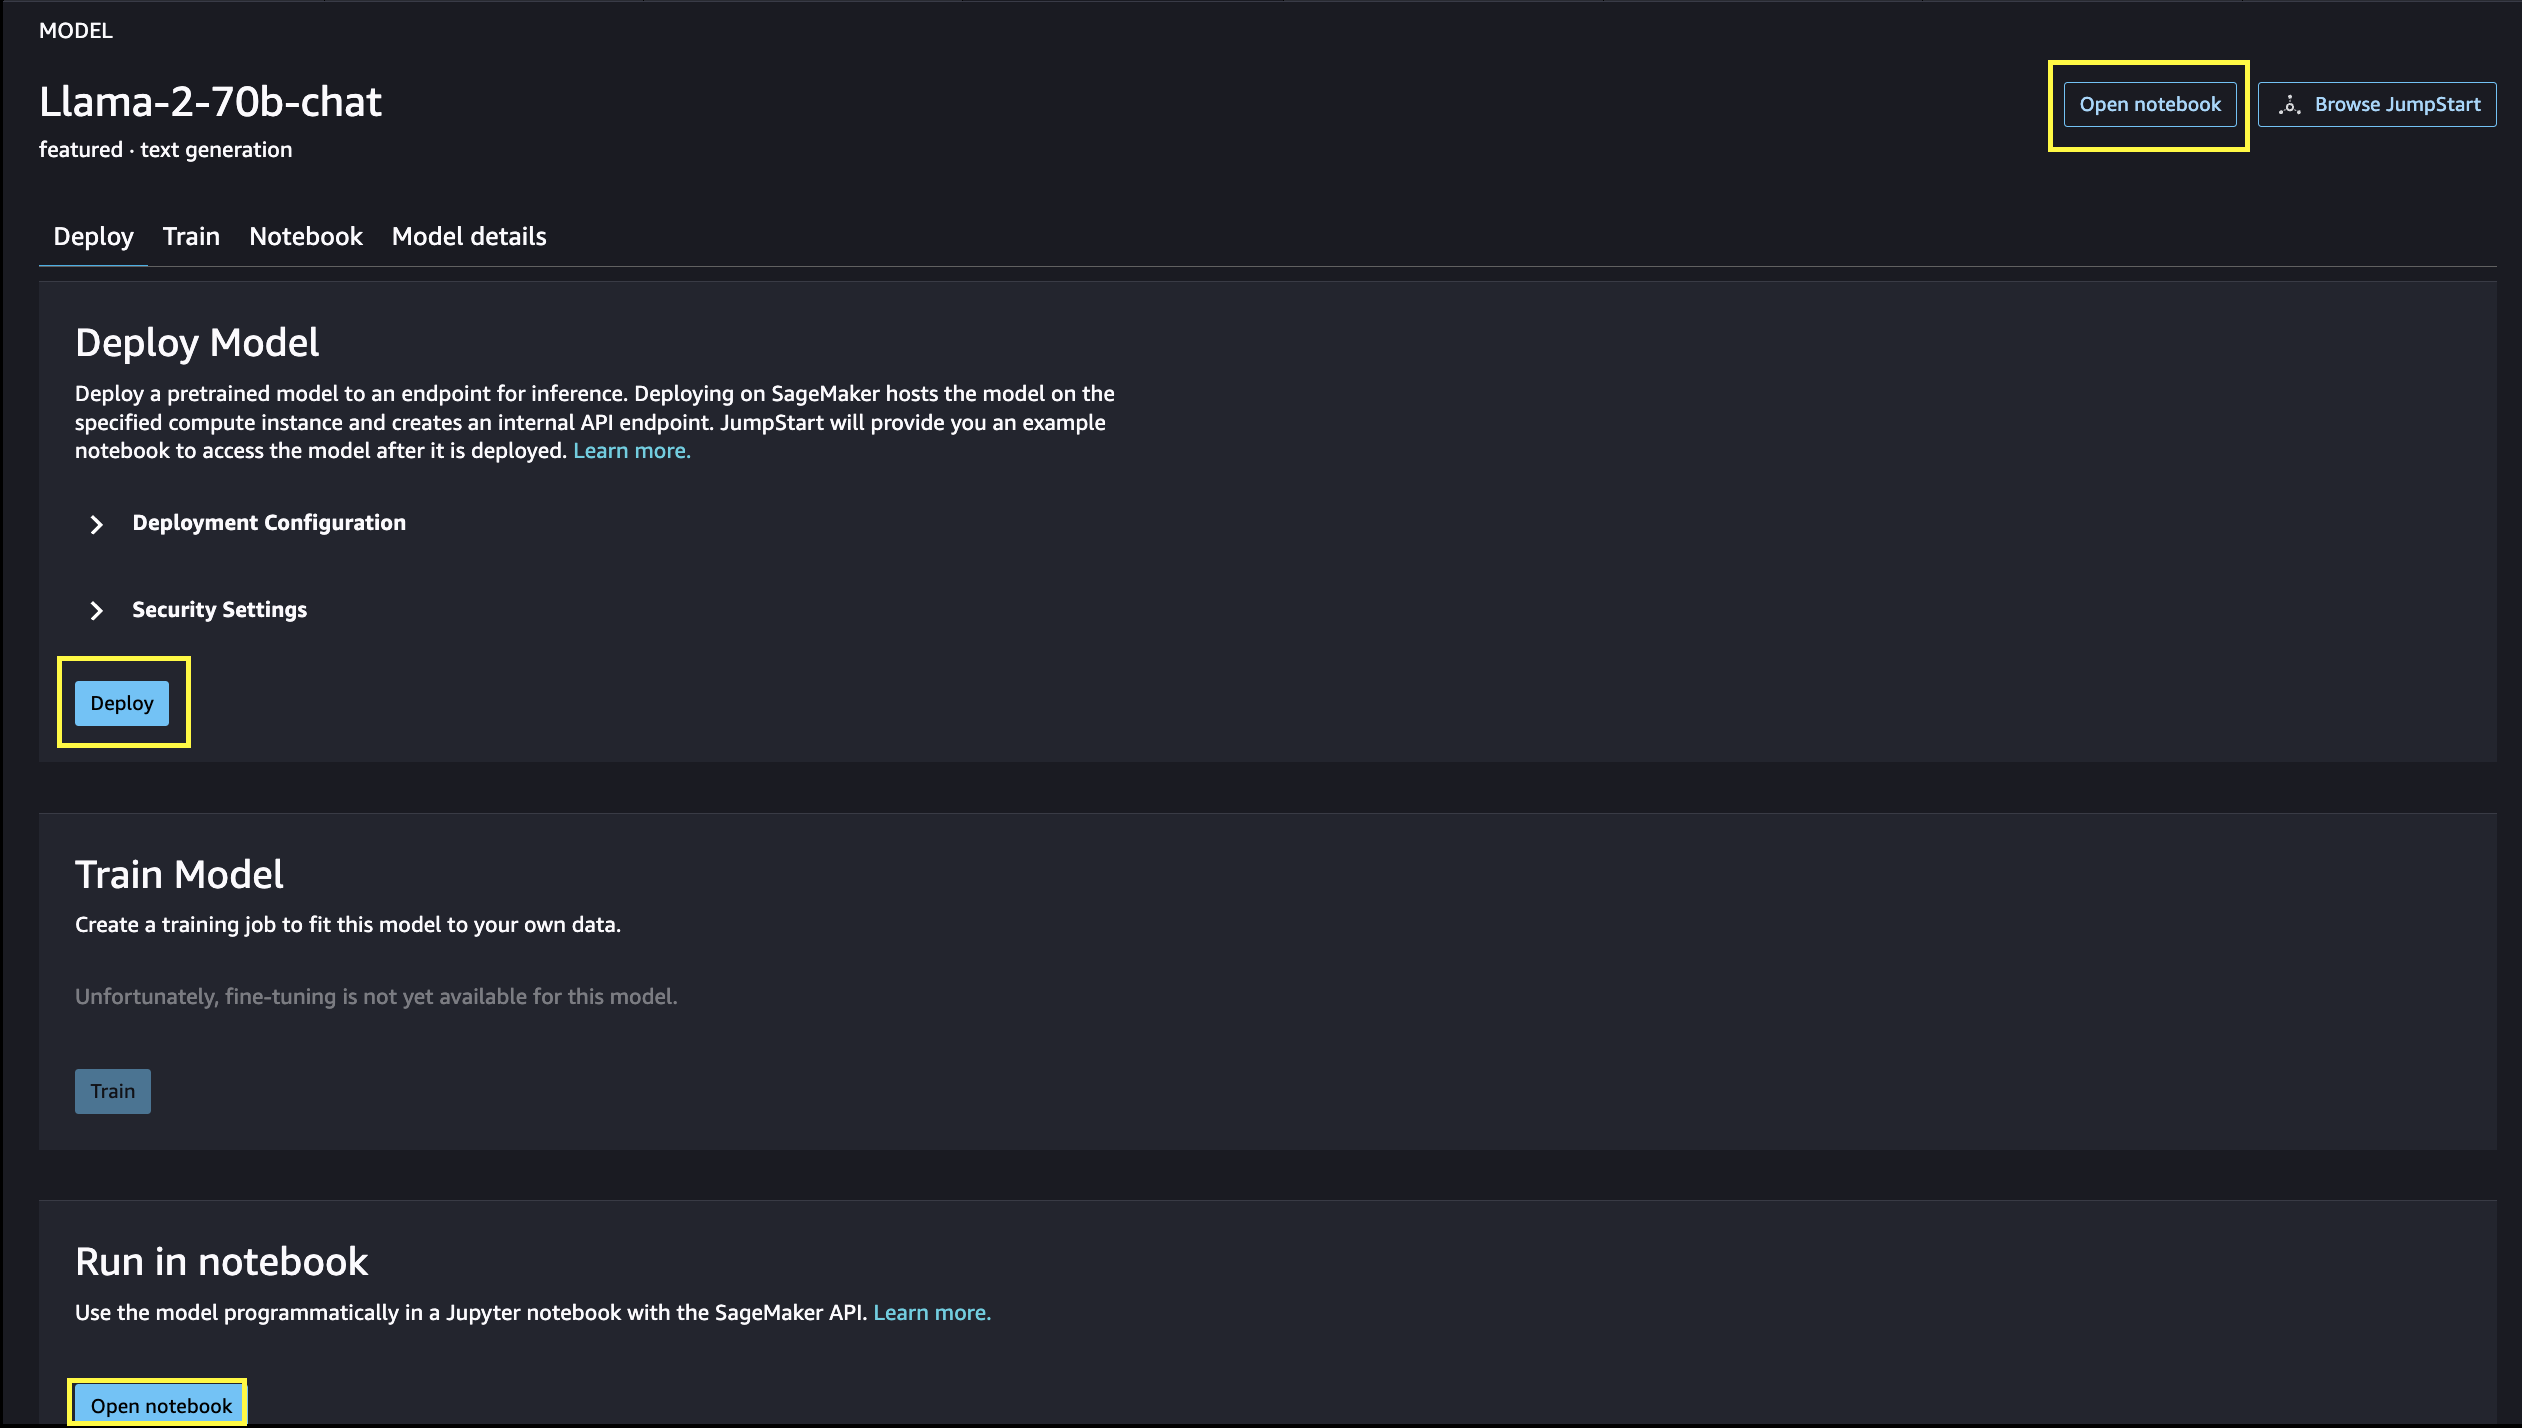

### Option B: Large Model Inference (LMI) with DJL Serving

Support the following LLM Inference libraries and frameworks:
- vLLM 
- TensorRT-LLM (coming soon) 
- DeepSpeed
- HuggingFace Accelerate
- Transformer NeuronX
- Optimum Neuron

https://docs.djl.ai/docs/demos/aws/sagemaker/large-model-inference/index.html

#### [OPTIONAL] Extend a Pre-built AWS Deep Learning Container

In case you need to update the package or modify the code in the pre-built AWS Deep Learning Container (DLC).<br>
https://github.com/aws/deep-learning-containers<br>
https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers

In SageMaker Studio Notebook, as it is a docker environment, you cannot run docker command. The workaround is to use `sm-docker build`.

**Prerequisites**
- Install the package `sagemaker-studio-image-build` in your Studio notebook environment
- Ensure the Amazon SageMaker execution role used by your Studio notebook environment has the required permissions to interact with the resources used by the CLI, including access to CodeBuild and Amazon ECR.

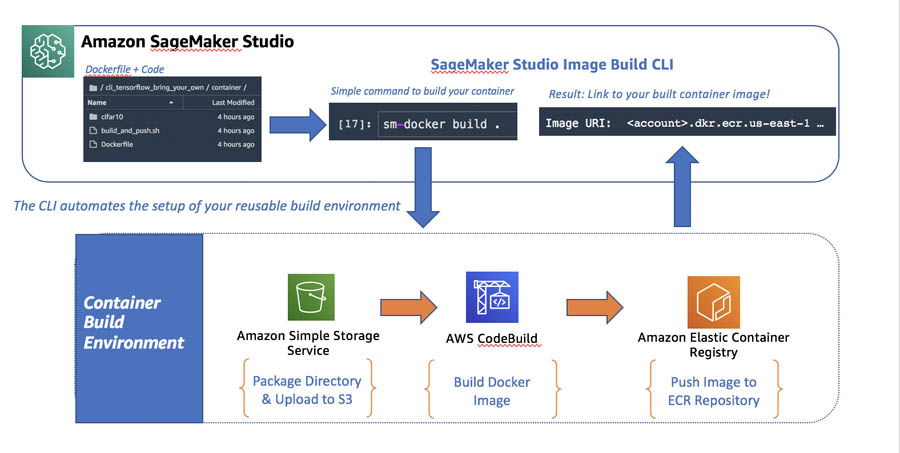

Ref: https://aws.amazon.com/blogs/machine-learning/using-the-amazon-sagemaker-studio-image-build-cli-to-build-container-images-from-your-studio-notebooks/

In [7]:
#!pip install sagemaker-studio-image-build

In [8]:
"""
from pathlib import Path

model_path = f"djl-serving"
Path(model_path).mkdir(parents=True, exist_ok=True)
"""

'\nfrom pathlib import Path\n\nmodel_path = f"djl-serving"\nPath(model_path).mkdir(parents=True, exist_ok=True)\n'

**Update vLLM to 0.2.2 to support ChatGLM and Yi models**

https://github.com/vllm-project/vllm/releases/tag/v0.2.2

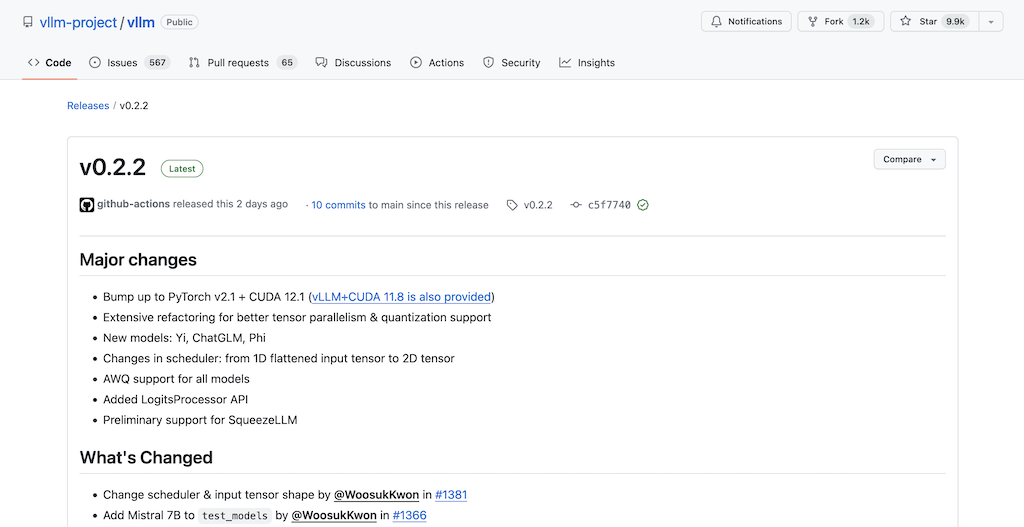

**Extend container image based on DJL-Inference v0.24.0 Dockerfile**
- vLLM version: v0.2.0

https://github.com/deepjavalibrary/djl-serving/blob/v0.24.0/serving/docker/deepspeed.Dockerfile

In [9]:
"""
%%writefile djl-serving/Dockerfile
FROM 763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.24.0-deepspeed0.10.0-cu118

RUN python3 -m pip install --upgrade pip

# Install vLLM 0.2.2 with CUDA 11.8.
RUN pip uninstall vllm -y
RUN pip install --no-cache-dir https://github.com/vllm-project/vllm/releases/download/v0.2.2/vllm-0.2.2+cu118-cp39-cp39-manylinux1_x86_64.whl 

# Re-install PyTorch and xFormers with CUDA 11.8.
RUN pip install torch==2.1.0 --upgrade --no-cache-dir --index-url https://download.pytorch.org/whl/cu118
RUN pip install xformers==0.0.22.post7 --upgrade --no-cache-dir --index-url https://download.pytorch.org/whl/cu118

# DJL-Inference Dockerfile: https://github.com/deepjavalibrary/djl-serving/blob/v0.24.0/serving/docker/deepspeed.Dockerfile
# vLLM 0.2.2: https://github.com/vllm-project/vllm/releases/tag/v0.2.2
"""

'\n%%writefile djl-serving/Dockerfile\nFROM 763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.24.0-deepspeed0.10.0-cu118\n\nRUN python3 -m pip install --upgrade pip\n\n# Install vLLM 0.2.2 with CUDA 11.8.\nRUN pip uninstall vllm -y\nRUN pip install --no-cache-dir https://github.com/vllm-project/vllm/releases/download/v0.2.2/vllm-0.2.2+cu118-cp39-cp39-manylinux1_x86_64.whl \n\n# Re-install PyTorch and xFormers with CUDA 11.8.\nRUN pip install torch==2.1.0 --upgrade --no-cache-dir --index-url https://download.pytorch.org/whl/cu118\nRUN pip install xformers==0.0.22.post7 --upgrade --no-cache-dir --index-url https://download.pytorch.org/whl/cu118\n\n# DJL-Inference Dockerfile: https://github.com/deepjavalibrary/djl-serving/blob/v0.24.0/serving/docker/deepspeed.Dockerfile\n# vLLM 0.2.2: https://github.com/vllm-project/vllm/releases/tag/v0.2.2\n'

In [10]:
"""
%%sh

cd djl-serving
sm-docker build . --repository djl-inference:0.24.0-deepspeed0.10.0-cu118-vllm0.2.2
"""

'\n%%sh\n\ncd djl-serving\nsm-docker build . --repository djl-inference:0.24.0-deepspeed0.10.0-cu118-vllm0.2.2\n'

In [67]:
"""
import boto3

repo = "djl-inference"
tag = "0.24.0-deepspeed0.10.0-cu118-vllm0.2.2"

ecr_client = boto3.client("ecr", region_name=region)
response = ecr_client.describe_registry()
ext_image_uri = f"{response['registryId']}.dkr.ecr.{region}.amazonaws.com/{repo}:{tag}"
print(ext_image_uri)
"""

468208999430.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.24.0-deepspeed0.10.0-cu118-vllm0.2.2


#### [OPTIONAL] Download the model from Hugging Face and upload to Amazon S3

In [ ]:
"""
from pathlib import Path

model_path = f"{HF_MODEL_ID.replace('/', '_')}"
Path(model_path).mkdir(parents=True, exist_ok=True)
"""

In [13]:
"""
from huggingface_hub import snapshot_download

#HF_MODEL_ID="TheBloke/Llama-2-7b-chat-fp16"
#HF_MODEL_ID="meta-llama/Llama-2-7b-chat-hf"
#HF_TOKEN=<Your HF Token>

model_path = snapshot_download(repo_id=HF_MODEL_ID, 
                               #token=HF_TOKEN,
                               #ignore_patterns=["*.bin"], 
                               cache_dir=model_path,
                               local_dir=model_path, 
                               local_dir_use_symlinks=False)
"""

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

USE_POLICY.md:   0%|          | 0.00/4.77k [00:00<?, ?B/s]

LICENSE.txt:   0%|          | 0.00/7.02k [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/770 [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

In [16]:
"""
# upload files from local to S3 location
s3_model_prefix = f"huggingface-hub/{HF_MODEL_ID}/model"

s3_model_location = sess.upload_data(path=model_path, key_prefix=s3_model_prefix)
print(f"Model uploaded to --- > {s3_model_location}")
"""

Model uploaded to --- > s3://sagemaker-us-east-1-468208999430/huggingface-hub/TheBloke/Llama-2-7b-chat-fp16/model


#### Prepare `serving.properties` configuration file

Before deploying your model on SageMaker, you must package your model artifacts in a .tar.gz file. DJL Serving accepts the following artifacts in your archive:


- **serving.properties**: A configuration file that you can add for each model. Place serving.properties in the same directory as your model file.

- [Optional] **requirements.txt**: A list of packages to be installed by pip, when using pip install.

- [Optional] **model.py**: The inference handler code. This is only applicable when using Python mode. If you don't specify model.py, djl-serving uses one of the default handlers.

- [Optional] **Model checkpoint**: Files that store your model weights (if you pack model in .tar.gz).


The following is an example of a model.tar.gz structure:

```bash
- model.tar.gz/ # root directory
    - serving.properties
    - requirements.txt # Optional
    - model.py # Optional
    - model binary files # Optional
```

https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-models-frameworks-djl-serving.html#deploy-models-frameworks-djl-artifacts

Here is an example of `serving.properties` with LMI-Dist

```python
engine = MPI
option.model_id = TheBloke/Llama-2-7b-chat-fp16 # If model is uploaded to S3, set model_id to S3 URL
option.task = text-generation
option.tensor_parallel_degree = 1
option.rolling_batch = auto
option.max_rolling_batch_size = 32
option.model_loading_timeout = 3600
option.paged_attention = true
option.trust_remote_code = true
option.dtype = fp16
option.enable_streaming = true
```

The following sections describe the configuration options you can use inside the `serving.properties` file.<br>
https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md<br>
[Outdated] https://docs.aws.amazon.com/sagemaker/latest/dg/large-model-inference-configuration.html


In [68]:
%%writefile serving.properties
# vLLM Configuration
engine = Python
option.model_id = {{model_id}}
option.tensor_parallel_degree = 1
option.rolling_batch = vllm
option.trust_remote_code = true
#option.quantize = awq

Overwriting serving.properties


In [139]:

"""
%%writefile serving.properties
# TensorRT-LLM Configuration (require at least g5.4xlarge to deploy Llama2 7B.
engine = MPI
option.model_id = {{model_id}}
option.tensor_parallel_degree = 1
option.trust_remote_code = true
#option.quantize = smoothquant
"""

Overwriting serving.properties


In [140]:
# Set to True if model is uploaded to S3
model_in_s3 = False 

model_id = HF_MODEL_ID 
if model_in_s3 == True and 's3_model_location' in locals():
    model_id = s3_model_location

In [141]:
import jinja2
from pathlib import Path

jinja_env = jinja2.Environment()

# we plug in the appropriate model location into our `serving.properties`
template = jinja_env.from_string(Path(f"serving.properties").open().read())
Path("serving.properties").open("w").write(
    template.render(model_id=model_id)
)
!pygmentize serving.properties | cat -n

     1	# TensorRT-LLM Configuration (require at least g5.4xlarge to deploy Llama2 7B.
     2	engine = MPI
     3	option.model_id = TheBloke/Llama-2-13b-chat-fp16
     4	option.tensor_parallel_degree = 1
     5	option.trust_remote_code = true
     6	option.quantize = smoothquant


In [142]:
!rm model.tar.gz
!tar czvf model.tar.gz serving.properties

serving.properties


**Additional packages for running Qwen model**<br>
https://huggingface.co/Qwen/Qwen-7B-Chat#%E4%BE%9D%E8%B5%96%E9%A1%B9%EF%BC%88dependency%EF%BC%89

In [143]:
"""
%%writefile requirements.txt
# Qwen-7B-Chat dependencies (https://huggingface.co/Qwen/Qwen-7B-Chat#%E4%BE%9D%E8%B5%96%E9%A1%B9%EF%BC%88dependency%EF%BC%89)
tiktoken 
transformers_stream_generator==0.0.4
"""

'\n%%writefile requirements.txt\n# Qwen-7B-Chat dependencies (https://huggingface.co/Qwen/Qwen-7B-Chat#%E4%BE%9D%E8%B5%96%E9%A1%B9%EF%BC%88dependency%EF%BC%89)\ntiktoken \ntransformers_stream_generator==0.0.4\n'

In [144]:
"""
!rm model.tar.gz
!tar czvf model.tar.gz serving.properties requirements.txt
"""

'\n!rm model.tar.gz\n!tar czvf model.tar.gz serving.properties requirements.txt\n'

In [145]:
# upload model.tar.gz from local to S3 location
s3_config_prefix = f"huggingface-hub/{HF_MODEL_ID}/config"

s3_config_artifact = sess.upload_data("model.tar.gz", bucket, s3_config_prefix)
print(f"Configuration uploaded to --- > {s3_config_artifact}")

Configuration uploaded to --- > s3://sagemaker-us-east-1-468208999430/huggingface-hub/TheBloke/Llama-2-13b-chat-fp16/config/model.tar.gz


#### Deploy Model

In [ ]:
from sagemaker import Model, image_uris, serializers, deserializers

name = sagemaker.utils.name_from_base(f"{HF_MODEL_ID.split('/')[-1]}-DJL")

djl_image = image_uris.retrieve(framework="djl-tensorrtllm", #"djl-deepspeed", 
                                region=region,
                                version="0.25.0"
                               )

model = Model(name=name,
              model_data=s3_config_artifact, 
              image_uri=djl_image, 
              #image_uri=ext_image_uri, # If extend a Pre-built AWS Deep Learning Container image
              role=role
             )

predictor = model.deploy(endpoint_name=name,
                         initial_instance_count=1,
                         instance_type="ml.g5.16xlarge", 
                         #volume_size=100,
                         model_data_download_timeout = 600,
                         container_startup_health_check_timeout=600,
                         wait=False
                        )

In [ ]:
import boto3
import time

sm_client = boto3.client("sagemaker", region_name=region)

while True:
    resp = sm_client.describe_endpoint(EndpointName=name)
    status = resp["EndpointStatus"]
    print("Status: " + status)
    if status != "Creating":
        break
    time.sleep(60)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

### Option C: Text Generation Inference (TGI) from Hugging Face

Hugging Face on SageMaker: https://huggingface.co/docs/sagemaker/inference<br>
Hugging Face LLM Inference DLC: https://huggingface.co/blog/sagemaker-huggingface-llm

Supported Models: https://huggingface.co/docs/text-generation-inference/supported_models#supported-models

#### [OPTIONAL] Download the model from Hugging Face and upload the model artifacts on Amazon S3

Before deploying your model on SageMaker, you can package your model artifacts in a .tar.gz file. 

The following is an example of a model.tar.gz structure:

```bash
model.tar.gz/
|- pytorch_model.bin
|- vocab.txt
|- tokenizer_config.json
|- config.json
|- special_tokens_map.json
```

https://huggingface.co/docs/sagemaker/inference#user-defined-code-and-modules

In [ ]:
"""
from pathlib import Path

model_path = f"{HF_MODEL_ID.replace('/', '_')}"
Path(model_path).mkdir(parents=True, exist_ok=True)
"""

In [ ]:
"""
from huggingface_hub import snapshot_download

#HF_MODEL_ID="TheBloke/Llama-2-7b-chat-fp16"
#HF_MODEL_ID="meta-llama/Llama-2-7b-chat-hf"
#HF_TOKEN=<Your HF Token>

model_path = snapshot_download(repo_id=HF_MODEL_ID, 
                               #token=HF_TOKEN,
                               #ignore_patterns=["*.bin"], 
                               cache_dir=model_path,
                               local_dir=model_path, 
                               local_dir_use_symlinks=False)
"""

In [ ]:
"""
import tarfile
import os

# helper to create the model.tar.gz
def compress(tar_dir=None, ignore_extensions=[], output_file="model.tar.gz"):
    parent_dir=os.getcwd()
    os.chdir(tar_dir)
    with tarfile.open(os.path.join(parent_dir, output_file), "w:gz") as tar:
        for item in os.listdir('.'):
            if any(ext in item for ext in ignore_extensions):
                print(f"Ignore {item}")
                continue
            print(f"Add {item}")
            tar.add(item, arcname=item)     
    os.chdir(parent_dir)

compress(model_path, ignore_extensions=['.bin']) #Eg. ignore_extensions=['.bin']
"""

In [ ]:
"""
# upload model.tar.gz from local to S3 location
s3_llm_prefix = f"huggingface-hub/{HF_MODEL_ID}"

s3_llm_artifact = sess.upload_data("model.tar.gz", bucket, key_prefix=s3_llm_prefix)
print(f"Model artifact uploaded to --- > {s3_llm_artifact}")
"""

#### Deploy Model

If deploy from the model artifacts uploaded to Amazon S3, set
```python
- 'HF_MODEL_ID': '/opt/ml/model' in Hub Model configuration
- model_data = s3_llm_artifact in `HuggingFaceModel`
```

In [46]:
from sagemaker.huggingface import HuggingFaceModel
from sagemaker.huggingface import get_huggingface_llm_image_uri
from sagemaker import Model, image_uris, serializers, deserializers

name = sagemaker.utils.name_from_base(f"{HF_MODEL_ID.split('/')[-1]}-TGI")

model_in_s3 = True # Set to True if model is uploaded to S3
    
# Hub Model configuration. https://github.com/huggingface/text-generation-inference/blob/main/sagemaker-entrypoint.sh
hub = {
    'HF_MODEL_ID': HF_MODEL_ID if model_in_s3 == False else '/opt/ml/model', # model_id from hf.co/models
    'HF_MODEL_TRUST_REMOTE_CODE': "true",
    #'HF_MODEL_QUANTIZE': "bitsandbytes", # https://huggingface.co/docs/text-generation-inference/conceptual/quantization
    #'SM_NUM_GPUS': json.dumps(number_of_gpu), # Number of GPU used per replica
    
    #------------------- No use in TGI --------------------#
    #'HF_TASK': 'text-generation',
    #'MAX_INPUT_LENGTH': json.dumps(1024),  # Max length of input text
    #'MAX_TOTAL_TOKENS': json.dumps(2048),  # Max length of the generation (including input text)
    
}

# retrieve the llm image uri
llm_image = get_huggingface_llm_image_uri("huggingface", version="1.1.0")

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(name=name,
                                     env=hub,
                                     #model_data=s3_llm_artifact, # If model is uploaded to S3, set model_data to S3 URL
                                     image_uri=llm_image,
                                     role=role
                                    )

llm_predictor = huggingface_model.deploy(endpoint_name=name,
                                         initial_instance_count=1,
                                         instance_type="ml.g5.2xlarge",
                                         #volume_size=100,
                                         model_data_download_timeout = 900,
                                         container_startup_health_check_timeout=900,
                                         wait=False
                                        )

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [ ]:
import boto3
import time

sm_client = boto3.client("sagemaker", region_name=region)

while True:
    resp = sm_client.describe_endpoint(EndpointName=name)
    status = resp["EndpointStatus"]
    print("Status: " + status)
    if status != "Creating":
        break
    time.sleep(60)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

## LLM Inference with SageMaker Endpoint

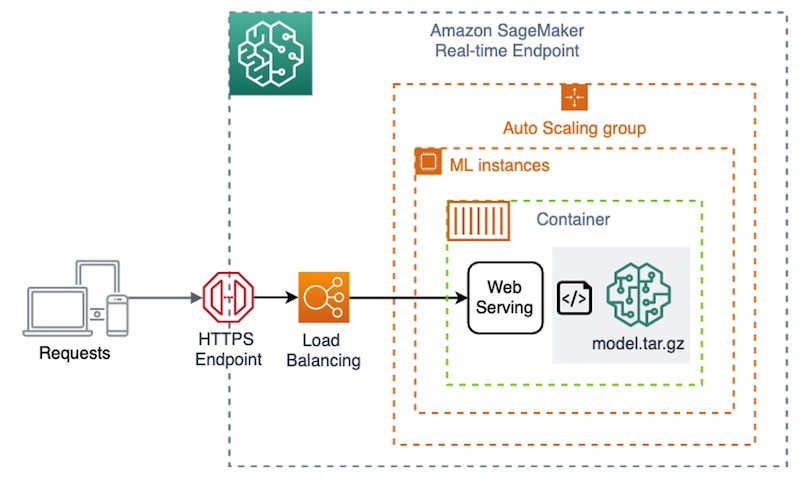

### Input/Output Format

#### Option A: SageMaker JumpStart (Depends on Model, check in JumpStart Notebook)

eg. Llama-2-7b-Chat
##### Input

```json
{ "inputs": [ [{ "role": "system",  "content": "<system_prompt>" },
               { "role": "user",  "content": "<prompt>" },
               { "role": "assistant",  "content": "<prompt>" },
               { "role": "user",  "content": "<prompt>" },
               ...
            ] ],
  "parameters": { "max_new_tokens":512, ... }
}
```

#### Output

```json
[{ 'generation': { 'role': 'assistant',
                   'content': "<output>" }
}]
```

#### Option B: Large Model Inference (LMI) with DJL Serving

##### Input

```json
{ "inputs": "<prompt>", 
  "parameters": { "max_new_tokens":512, ... }
}
```

##### Output

```json
{ "generated_text": "<output>" }
```

#### Option C: Text Generation Inference (TGI) from Hugging Face

##### Input

```json
{ "inputs": "<prompt>", 
  "parameters": { "max_new_tokens":512, ... }
}
```

##### Output

```json
[{ "generated_text": "<output>" }]
```

### Invoke Endpoint

In [50]:
import boto3
import sagemaker

sm_client = boto3.client("sagemaker", region_name=region)
smr_client = boto3.client("sagemaker-runtime", region_name="us-east-1")

print("-------------- SageMaker Endpoint List --------------")
endpoints = sm_client.list_endpoints(StatusEquals="InService")
for endpoint in endpoints['Endpoints']:
    print(endpoint['EndpointName'])

print("")
print("Enter endpoint name to use the model")
print("-------------------------------------")
endpoint_name = input()


# our requests and responses will be in json format so we specify the serializer and the deserializer

#llm_predictor = sagemaker.Predictor(
#    endpoint_name = endpoint_name,
#    sagemaker_session = sagemaker.session.Session(),  # sagemaker session for interacting with different AWS APIs
#    serializer = sagemaker.serializers.JSONSerializer(),
#    deserializer = sagemaker.deserializers.JSONDeserializer()
#)
print("")
print("Model loaded!")

-------------- SageMaker Endpoint List --------------
Llama-2-13B-chat-AWQ-DJL-2023-11-28-09-24-14-832
all-MiniLM-L6-v2-2023-11-18-15-07-22-162
mlops-jenkins-yolov4-prod
mlops-jenkins-yolov4-staging

Enter endpoint name to use the model
-------------------------------------


 Llama-2-13B-chat-AWQ-DJL-2023-11-28-09-24-14-832



Model loaded!


In [33]:
prompt = "tell me a story of the little red riding hood"

In [55]:
import json
import time

print("Input Prompt")
print("------------")
prompt = input()

print("")
print("Loading...")

payload = {
    "inputs": prompt, 
    #"inputs": [[{ "role": "user", "content": prompt }]], # Use this if SageMaker JumpStart (Llama2 Chat)
    "parameters": {
        "max_new_tokens": 512, # check config.json / generation_config.json / tokenizer_config.json
        "temperature": 0.9,
        #"top_p": 0.9, 
        #"do_sample": True,
        #"return_full_text": False,
        #"stop": ["</s>", "<|endoftext|>"]
    }
}

t0 = time.time()
response = smr_client.invoke_endpoint(EndpointName=endpoint_name, 
                                      Body=json.dumps(payload),#.encode('utf-8'),
                                      Accept="application/json",
                                      ContentType="application/json",
                                      #CustomAttributes="accept_eula=true" # Required by Llama2 models deployed in SageMaker JumpStart
                                     )
t1 = time.time()
result = json.loads(response["Body"].read().decode('utf-8'))

#result = llm_predictor.predict(payload, 
#                               #custom_attributes="accept_eula=true" # Required by Llama2 models deployed in SageMaker JumpStart
#                              )

print("")
print(result)

time_elapsed = (t1-t0)*1000
print("")
print(f"Time Elasped: {time_elapsed} ms")

Input Prompt
------------


 Human: Use the following pieces of context to provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. <context> There are civil penalties for failure to: File a correct Form 8300 by the date it is  due, and Provide the required statement to those  named in the Form 8300. If you intentionally disregard the requirement  to file a correct Form 8300 by the date it is due,  the penalty is the greater of: 1.$25,000, or 2.The amount of cash you received and  were required to report (up to $100,000). There are criminal penalties for: Willful failure to file Form 8300, Willfully filing a false or fraudulent Form  8300, Stopping or trying to stop Form 8300 from  being filed, and Setting up, helping to set up, or trying to  set up a transaction in a way that would  make it seem unnecessary to file Form  8300. If you willfully fail to file Form 8300, you can  be fined up to $250,000 for individuals  RECORDS($


Loading...

{'generated_text': " Based on the information provided, it is possible that you could be sentenced to jail if you willfully fail to file Form 8300 or file a false or fraudulent Form 8300. These actions can be considered criminal offenses, and penalties can include fines of up to $250,000 for individuals (or $500,000 for corporations) and/or up to 5 years in prison. However, the likelihood of jail time due to a failure to file Form 8300 is relatively low, and it would depend on the specific circumstances of the case. It's important to note that the IRS takes compliance with the reporting requirements seriously, and failure to file Form 8300 can result in significant penalties and interest, as well as potential criminal prosecution. If you have failed to file Form 8300 or have any other questions or concerns regarding your tax obligations, it is recommended that you seek the advice of a qualified tax professional or an attorney."}

Time Elasped: 6228.022813796997 ms


In [39]:
print(result['generated_text'])


2022.01.22 00:56 mysterique7777 Tell me a story of Little Red Riding Hood.
Once upon a time, there was a young girl named Little Red Riding Hood who lived in a small village at the edge of a forest. She was a kind and gentle soul, always eager to help those in need. One sunny day, she set out to visit her sick grandmother who lived in a cottage deep in the woods.
As she walked through the forest, she noticed that the trees seemed to be growing taller and the shadows seemed to be getting darker. She heard a rustling in the bushes and suddenly a big bad wolf appeared before her!
"Where are you going, little girl?" asked the wolf in a menacing voice.
"I'm on my way to visit my sick grandmother," replied Little Red Riding Hood, trying to hide her fear.
"Ah, your grandmother's cottage is just what I'm looking for," said the wolf with a sly grin. "I'll come with you and eat her up!"
Little Red Riding Hood knew that she had to think quickly or else she would be in great danger. She thought o

## Langchain Integration

In [40]:
import langchain

langchain.verbose = True

In [44]:
endpoint_name = "Llama-2-7b-chat-fp16-vLLM-2023-11-24-08-30-30-434"

In [45]:
import boto3
from langchain.llms import SagemakerEndpoint
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from typing import Dict

smr_client = boto3.client("sagemaker-runtime", region_name="us-east-1")

class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs: Dict) -> bytes:
        input_str = json.dumps({"inputs": prompt, **model_kwargs}) # LMI and TGI
        #input_str = json.dumps({"inputs": [[{"role": "user", "content": prompt}]], **model_kwargs}) # SageMaker JumpStart
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json["generated_text"] # LMI
        #return response_json[0]["generated_text"] # TGI
        #return response_json[0]["generation"]['content'] # SageMaker JumpStart


llm = SagemakerEndpoint(endpoint_name = endpoint_name,
                        client = smr_client,
                        model_kwargs = {
                            "parameters": {
                                "max_new_tokens":1024, 
                                #"top_p": 0.1, 
                                "temperature": 0.1,
                                #"do_sample": True,
                                #"return_full_text": False,
                                "stop": ["</s>", "<|endoftext|>"]
                            }
                        },
                        #endpoint_kwargs = {"CustomAttributes": 'accept_eula=true'}, # Required by Llama2 models deployed in SageMaker JumpStart
                        content_handler = ContentHandler()
                       )

In [46]:
import json

print(llm.predict("tell me a story of the little red riding hood"))



Little Red Riding Hood is a classic fairy tale that has been passed down for generations. The story goes like this:

Once upon a time, there was a little girl named Little Red Riding Hood who lived in a small village at the edge of a forest. She was a kind and gentle child, always dressed in a bright red hooded cloak, which she wore to keep her head warm on chilly days.
One day, Little Red Riding Hood's mother asked her to take a basket of freshly baked bread and butter to her sick grandmother who lived in a cottage at the other end of the forest. Little Red Riding Hood set off on her journey, singing and chatting to the birds as she walked.
As she walked deeper into the forest, she encountered a sly and cunning wolf who was known to be a trickster. The wolf asked Little Red Riding Hood where she was going, and she naively told him that she was on her way to visit her sick grandmother. The wolf's eyes lit up with excitement, and he asked if he could accompany her on her journey.
Litt

## Clean Up

In [138]:
import boto3
#import sagemaker

sm_client = boto3.client("sagemaker", region_name=region)

print("-------------- SageMaker Endpoint List --------------")
endpoints = sm_client.list_endpoints(StatusEquals="InService")
for endpoint in endpoints['Endpoints']:
    print(endpoint['EndpointName'])

print("")
print("Enter endpoint name to delete the model")
print("---------------------------------------")
endpoint_name = input()

sm_client.delete_model(ModelName=endpoint_name)    
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)


#llm_predictor = sagemaker.Predictor(
#    endpoint_name = endpoint_name,
#    sagemaker_session = sagemaker.session.Session(),  # sagemaker session for interacting with different AWS APIs
#    serializer = sagemaker.serializers.JSONSerializer(),
#    deserializer = sagemaker.deserializers.JSONDeserializer()
#)

#llm_predictor.delete_model()
#llm_predictor.delete_endpoint()

print("")
print("Model deleted!")

-------------- SageMaker Endpoint List --------------
Llama-2-7b-chat-fp16-DJL-2023-11-28-14-09-03-418
Llama-2-7b-chat-fp16-DJL-2023-11-28-11-52-37-106
Llama-2-13B-chat-AWQ-DJL-2023-11-28-09-24-14-832
all-MiniLM-L6-v2-2023-11-18-15-07-22-162
mlops-jenkins-yolov4-prod
mlops-jenkins-yolov4-staging

Enter endpoint name to delete the model
---------------------------------------


 Llama-2-7b-chat-fp16-DJL-2023-11-28-14-09-03-418



Model deleted!


## Extra - Multi Modal (Image-to-Text)

#### CLIP
https://github.com/aws/amazon-sagemaker-examples/blob/main/inference/generativeai/llm-workshop/lab13-clip-interrogator/deploy-clip-model-on-sagemaker.ipynb

#### BLIP
https://github.com/aws-samples/amazon-sagemaker-genai-content-moderation/blob/main/blip2-sagemaker.ipynb